Загружаем датасет. Я выбрал этот датасет, так как люблю машины.

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("trainingdatapro/car-masks")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/car-masks


Скачиваем библиотеку segmentation_models_pytorch

In [1]:
%pip install imantics segmentation_models_pytorch


Подгатавливаем датасет

In [31]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Задайте путь к данным
data_dir = path

class CloudSkyDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, img_size=(128, 128)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '.png'))

        # Загружаем изображение и маску
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        # Применяем трансформации
        if self.transform:
            image = self.transform(image)
            mask = mask.resize(self.img_size)  # Приводим маску к тому же размеру, что и изображение
            mask = np.array(mask)
            mask = torch.tensor(mask, dtype=torch.long)  # маски в формате long

        return image, mask

# Определим трансформации
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Приводим изображения к нужному размеру
    transforms.ToTensor(),
])

# Создадим датасет и загрузчик
train_dataset = CloudSkyDataset(os.path.join(data_dir, 'cars/img'), os.path.join(data_dir, 'cars/masks'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Пример
for img, mask in train_loader:
    print(img.shape, mask.shape)
    break

torch.Size([8, 3, 128, 128]) torch.Size([8, 128, 128])


Создаем модель Unet.

In [32]:
import segmentation_models_pytorch as smp

# Создаем модель U-Net
model = smp.Unet(
    encoder_name="resnet34",        # Используем ResNet34 как энкодер
    encoder_weights="imagenet",     # Предобученные веса на ImageNet
    in_channels=3,                  # Входные каналы (RGB)
    classes=1,                      # Количество классов (облако/необлако)
)

# Печать архитектуры модели
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Создаем функцию тренировки модели. Также добавляем рассчет метрик. Запускаем обучение

In [11]:
import torch
import numpy as np

# Функция для вычисления IoU
def iou_score(y_true, y_pred, threshold=0.5):
    # Преобразуем предсказания в бинарные значения
    y_pred = torch.sigmoid(y_pred)  # Применяем сигмоиду к предсказаниям
    y_pred = (y_pred > threshold).float()

    # Вычисляем пересечение и объединение
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred) - intersection

    return intersection / (union + 1e-6)  # Добавляем epsilon для предотвращения деления на ноль

# Функция для вычисления Dice Coefficient
def dice_score(y_true, y_pred, threshold=0.5):
    # Преобразуем предсказания в бинарные значения
    y_pred = torch.sigmoid(y_pred)  # Применяем сигмоиду к предсказаниям
    y_pred = (y_pred > threshold).float()

    # Вычисляем пересечение
    intersection = torch.sum(y_true * y_pred)

    return (2. * intersection) / (torch.sum(y_true) + torch.sum(y_pred) + 1e-6)  # Добавляем epsilon

In [33]:
from torch.optim import Adam
import torch.nn as nn
from tqdm import tqdm

# Функция для обучения модели с вычислением метрик
def train_model(model, train_loader, epochs=3, lr=1e-4):
    model.train()  # Переводим модель в режим тренировки
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()  # Потери для бинарной сегментации

    for epoch in range(epochs):
        loop = tqdm(train_loader, leave=True)  # Прогресс бар
        epoch_iou = 0
        epoch_dice = 0
        total_loss = 0

        for images, masks in loop:
            optimizer.zero_grad()

            # Перемещаем данные на GPU (если доступно)
            images = images.cuda()
            masks = masks.cuda().float()

            # Прогнозируем
            outputs = model(images)

            # Вычисляем потери
            loss = criterion(outputs, masks.unsqueeze(1))  # Маски должны быть 1-канальными
            loss.backward()
            optimizer.step()

            # Вычисляем метрики
            iou = iou_score(masks.unsqueeze(1), outputs)  # IoU
            dice = dice_score(masks.unsqueeze(1), outputs)  # Dice Coefficient

            # Обновляем метрики за эпоху
            epoch_iou += iou.item()
            epoch_dice += dice.item()
            total_loss += loss.item()

            # Обновляем прогресс
            loop.set_description(f"Epoch {epoch+1}/{epochs}")
            loop.set_postfix(loss=loss.item(), IoU=epoch_iou / (loop.n + 1), Dice=epoch_dice / (loop.n + 1))

        # Выводим усредненные метрики за эпоху
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss / len(train_loader):.4f} | IoU: {epoch_iou / len(train_loader):.4f} | Dice: {epoch_dice / len(train_loader):.4f}")

# Перемещаем модель на GPU (если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Запуск обучения
train_model(model, train_loader, epochs=3, lr=1e-4)

Epoch 1/3: 100%|██████████| 3/3 [00:07<00:00,  2.57s/it, Dice=0.747, IoU=0.597, loss=55.5]


Epoch 1/3 | Loss: 61.3221 | IoU: 0.5969 | Dice: 0.7469


Epoch 2/3: 100%|██████████| 3/3 [00:08<00:00,  2.81s/it, Dice=0.916, IoU=0.847, loss=34]


Epoch 2/3 | Loss: 38.8489 | IoU: 0.8469 | Dice: 0.9157


Epoch 3/3: 100%|██████████| 3/3 [00:09<00:00,  3.29s/it, Dice=1.06, IoU=1.14, loss=14.4]

Epoch 3/3 | Loss: 22.7619 | IoU: 1.1373 | Dice: 1.0612


Визуализация результатов


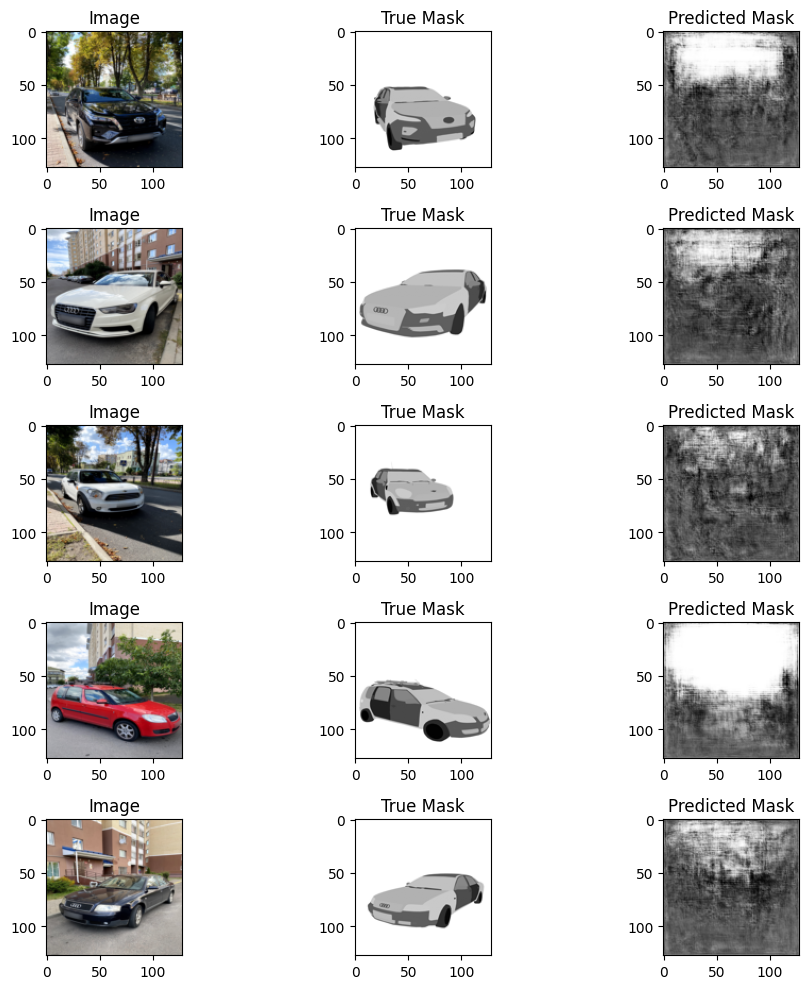

In [10]:
def visualize_predictions(model, dataset, num_images=5):
    model.eval()  # Переводим модель в режим оценки

    fig, axes = plt.subplots(num_images, 3, figsize=(10, 10))
    for i in range(num_images):
        image, true_mask = dataset[i]
        image = image.unsqueeze(0).to(device)  # Добавляем размер батча и переносим на GPU

        with torch.no_grad():
            output = model(image)
            pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()  # Получаем вероятности и сжимаем

        # Визуализация
        axes[i, 0].imshow(image.squeeze().cpu().permute(1, 2, 0))  # Изображение
        axes[i, 0].set_title("Image")
        axes[i, 1].imshow(true_mask.squeeze(), cmap='gray')  # Истинная маска
        axes[i, 1].set_title("True Mask")
        axes[i, 2].imshow(pred_mask, cmap='gray')  # Прогнозируемая маска
        axes[i, 2].set_title("Predicted Mask")

    plt.tight_layout()
    plt.show()

# Визуализация
visualize_predictions(model, train_dataset)

Для улучшения бейздайна можно добавить аугментацию данных.

In [23]:
data_dir = path

class CloudSkyDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, img_size=(128, 128)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '.png'))

        # Загружаем изображение и маску
        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'))

        # Применяем аугментации, если они есть
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Преобразуем изображение и маску в тип float32
        image = torch.tensor(image, dtype=torch.float32)  # Преобразуем изображение в FloatTensor
        mask = torch.tensor(mask, dtype=torch.float32)    # Преобразуем маску в FloatTensor

        # Нормализуем изображение в диапазон [0, 1]
        image /= 255.0

        # Изменяем порядок каналов: (H, W, C) -> (C, H, W)
        image = image.permute(2, 0, 1)  # Изменяем из (H, W, C) в (C, H, W)

        # Проверим форму изображения и маски
        print(f"Image shape after permute: {image.shape}")  # Debugging line
        print(f"Mask shape: {mask.shape}")  # Debugging line

        return image, mask



# Определяем аугментации
transform = A.Compose([
    A.Resize(128, 128),  # Приводим к нужному размеру
    A.RandomCrop(width=128, height=128),  # Случайный обрез
    A.HorizontalFlip(p=0.5),  # Случайное горизонтальное отражение
    A.RandomBrightnessContrast(p=0.2),  # Случайная яркость/контрастность
    A.Rotate(limit=30, p=0.5),  # Случайный поворот до 30 градусов
    A.GaussianBlur(blur_limit=3, p=0.1),  # Размытие
    ToTensorV2(),  # Преобразуем в тензор
])

# Создаем датасет и загрузчик
train_dataset = CloudSkyDataset(os.path.join(data_dir, 'cars/img'), os.path.join(data_dir, 'cars/masks'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


for img, mask in train_loader:
    print(img.shape, mask.shape)
    break


<ipython-input-23-ee28be39408e>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)  # Преобразуем изображение в FloatTensor
<ipython-input-23-ee28be39408e>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)    # Преобразуем маску в FloatTensor


Image shape after permute: torch.Size([128, 3, 128])
Mask shape: torch.Size([128, 128])
Image shape after permute: torch.Size([128, 3, 128])
Mask shape: torch.Size([128, 128])
Image shape after permute: torch.Size([128, 3, 128])
Mask shape: torch.Size([128, 128])
Image shape after permute: torch.Size([128, 3, 128])
Mask shape: torch.Size([128, 128])
Image shape after permute: torch.Size([128, 3, 128])
Mask shape: torch.Size([128, 128])
Image shape after permute: torch.Size([128, 3, 128])
Mask shape: torch.Size([128, 128])
Image shape after permute: torch.Size([128, 3, 128])
Mask shape: torch.Size([128, 128])
Image shape after permute: torch.Size([128, 3, 128])
Mask shape: torch.Size([128, 128])
torch.Size([8, 128, 3, 128]) torch.Size([8, 128, 128])


Собственная имплементация.

In [4]:
data_dir = path

# Функция загрузки данных
def load_data(data_dir, img_size=(128, 128)):
    images = []
    masks = []

    # Проходим по всем изображениям
    for img_name in os.listdir(os.path.join(data_dir, 'cars/img')):
        if img_name.endswith('.jpg'):
            img_path = os.path.join(data_dir, 'cars/img', img_name)
            mask_path = os.path.join(data_dir, 'cars/masks', img_name.replace('.jpg', '.png'))  # Имя маски соответствует изображению

            # Загружаем изображения и маски
            img = load_img(img_path, target_size=img_size)
            mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")  # Маски - в оттенках серого

            images.append(img_to_array(img))
            masks.append(img_to_array(mask))

    images = np.array(images) / 255.0  # Нормализуем изображения
    masks = np.array(masks) / 255.0  # Нормализуем маски

    # Убедимся, что маски бинарные
    masks = np.round(masks)  # Округляем маски до 0 или 1

    return images, masks

# Загружаем и делим данные
images, masks = load_data(data_dir)
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(16, 128, 128, 3) (16, 128, 128, 1) (4, 128, 128, 3) (4, 128, 128, 1)


Имплементация модели

In [5]:
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Этапы энкодера
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)

    # Этапы декодера
    up5 = layers.UpSampling2D((2, 2))(pool4)
    concat5 = layers.concatenate([up5, conv4], axis=-1)
    conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.UpSampling2D((2, 2))(conv5)
    concat6 = layers.concatenate([up6, conv3], axis=-1)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.UpSampling2D((2, 2))(conv6)
    concat7 = layers.concatenate([up7, conv2], axis=-1)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = layers.UpSampling2D((2, 2))(conv7)
    concat8 = layers.concatenate([up8, conv1], axis=-1)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat8)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    # Выходной слой
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv8)

    model = models.Model(inputs, outputs)
    return model

# Создаем модель
model = unet_model()

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Печать архитектуры модели
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ max_pooling2d_3[… │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 1024)             │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,104 │ concatenate[0][0] │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]  

 Total params: 14,861,825 (56.69 MB)

 Trainable params: 14,861,825 (56.69 MB)

 Non-trainable params: 0 (0.00 B)

Обучение своей модели

In [6]:
# Обучение модели
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8)

# Оценка модели на валидационной выборке
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.3749 - loss: 0.6792 - val_accuracy: 0.9072 - val_loss: 12.8398
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 227ms/step - accuracy: 0.9025 - loss: 8.9077 - val_accuracy: 0.9072 - val_loss: 0.6101
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.9023 - loss: 0.6113 - val_accuracy: 0.9072 - val_loss: 0.6117
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9061 - loss: 0.6053 - val_accuracy: 0.9072 - val_loss: 0.5713
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9030 - loss: 0.5492 - val_accuracy: 0.9072 - val_loss: 0.3666
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9059 - loss: 0.5085 - val_accuracy: 0.9072 - val_loss: 0.3479
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.9065 - loss: 0.3473 - val_accuracy: 0.9072 - val_loss: 0.4172
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9045 - loss: 0.4175 - val_accuracy: 0.9072 - val_loss:

Результаты

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


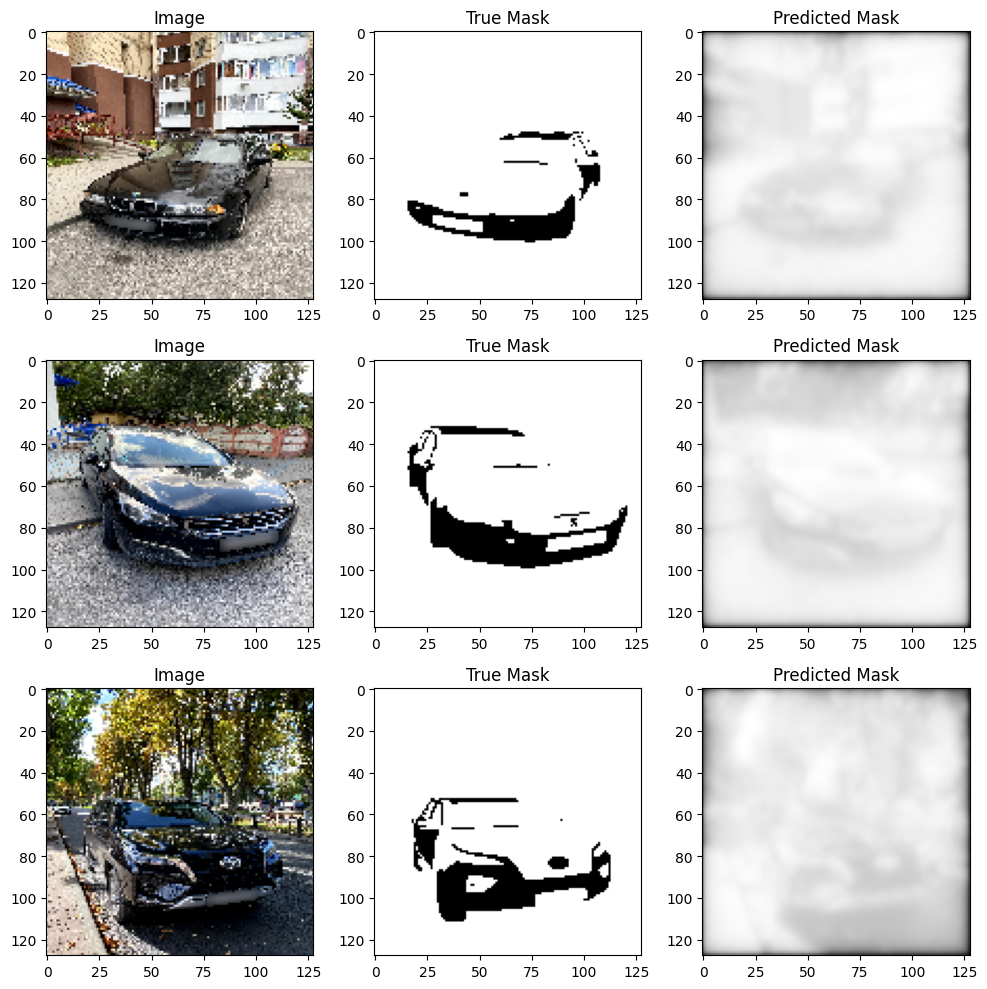

In [8]:
# Прогноз на изображениях
def predict_and_plot(model, X_val, y_val, num_images=3):
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 10))
    for i in range(num_images):
        # Получаем изображение, маску и предсказание
        img = X_val[i]
        true_mask = y_val[i]
        pred_mask = model.predict(img[np.newaxis, ...])[0]

        # Показываем изображение, маску и предсказание
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Image")
        axes[i, 1].imshow(true_mask[..., 0], cmap='gray')
        axes[i, 1].set_title("True Mask")
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")

    plt.tight_layout()
    plt.show()

# Визуализация
predict_and_plot(model, X_val, y_val)


Реализация для Segformer


In [43]:
class CloudSkyDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=(128, 128)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir

        # Проверка существования папок
        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Directory for images not found: {image_dir}")
        if not os.path.exists(mask_dir):
            raise FileNotFoundError(f"Directory for masks not found: {mask_dir}")

        # Получаем все файлы изображений
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

        # Проверка на наличие файлов
        if len(self.image_files) == 0:
            raise FileNotFoundError(f"No .jpg files found in directory: {image_dir}")

        self.img_size = img_size

        # Преобразования: изменение размера и преобразование в тензор
        self.transform = transforms.Compose([
            transforms.Resize((self.img_size[0] // 32 * 32, self.img_size[1] // 32 * 32)),  # Паддинг до размера, кратного 32
            transforms.ToTensor(),  # Преобразование в тензор
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '.png'))

        # Загружаем изображение и маску
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Маска в оттенках серого

        # Применяем преобразования для изображения
        image = self.transform(image)

        # Преобразуем маску в тензор и изменяем размер маски
        mask = np.array(mask)
        mask = Image.fromarray(mask)
        mask = mask.resize((self.img_size[0] // 32 * 32, self.img_size[1] // 32 * 32), Image.NEAREST)  # Маска подгоняется под размер изображения
        mask = np.array(mask)

        # Преобразуем маску в тензор
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Добавляем размерность канала

        return image, mask

# Путь к данным
image_dir = '//kaggle/input/car-masks/cars/img'  # Замените на правильный путь
mask_dir = '/kaggle/input/car-masks/cars/masks'  # Замените на правильный путь

# Создание датасета без аугментации
train_dataset = CloudSkyDataset(image_dir=image_dir, mask_dir=mask_dir)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Использование SegFormer из segmentation_models.pytorch
model = smp.Segformer(
    encoder_name="timm-efficientnet-b0",  # Используем EfficientNet-b0 в качестве энкодера
    encoder_weights="imagenet",  # Веса ImageNet
    in_channels=3,  # Количество каналов входного изображения (RGB)
    classes=1,  # Класс для сегментации (1 для бинарной маски)
    activation='sigmoid'  # Для бинарной сегментации используем sigmoidal активацию
)

# Использование GPU, если доступно
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Определение функции потерь и оптимизатора
criterion = torch.nn.BCEWithLogitsLoss()  # Для бинарной сегментации
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Функция для вычисления IoU
def iou_metric(y_true, y_pred):
    # Порог для преобразования предсказаний в бинарные значения
    y_pred = torch.sigmoid(y_pred) > 0.5  # Преобразуем предсказания в бинарные значения

    # Преобразуем в numpy массивы для вычислений
    y_true = y_true.cpu().numpy().flatten()
    y_pred = y_pred.cpu().numpy().flatten()

    # Находим пересечение и объединение
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = intersection / union if union != 0 else 0.0

    return iou

# Обучение модели
def train_model(model, train_loader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        running_iou = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Прямой проход
            outputs = model(inputs)

            # Вычисление потерь
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Метрики IoU
            iou = iou_metric(labels, outputs)

            running_loss += loss.item()
            running_iou += iou

            if i % 10 == 0:  # Печать каждые 10 батчей
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item()}, IoU: {iou}")

        epoch_loss = running_loss / len(train_loader)
        epoch_iou = running_iou / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss}, IoU: {epoch_iou}")

# Обучение
train_model(model, train_loader, criterion, optimizer, epochs=3)


Epoch [1/3], Batch [1/3], Loss: -107.19377136230469, IoU: 227.8626708984375
Epoch [1/3] - Loss: -108.46333821614583, IoU: 228.35638427734375
Epoch [2/3], Batch [1/3], Loss: -115.24375915527344, IoU: 229.02603149414062
Epoch [2/3] - Loss: -115.48707580566406, IoU: 228.00604248046875
Epoch [3/3], Batch [1/3], Loss: -119.54866790771484, IoU: 226.5741424560547
Epoch [3/3] - Loss: -121.78402709960938, IoU: 229.59467569986978
